 # Set Up Your Environment:

In [4]:
pip install pandas numpy scikit-learn matplotlib seaborn transformers datasets sentence-transformers gradio

In [5]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import torch
import torch

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP - NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Hugging Face Datasets & Transformers
from datasets import Dataset
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    BertTokenizer, BertForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# 1: Load and Preprocess the Data

 ## (A) Load the dataset



Reads the dataset from the CSV file into a Pandas DataFrame

In [61]:
df1 = pd.read_csv("new_data.csv") #combain between 3 dataset
df2 = pd.read_csv("All_Beauty.csv")

<ipython-input-61-584f442b401c>:1: DtypeWarning: Columns (8,10,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("new_data.csv") #combain between 3 dataset
<ipython-input-61-584f442b401c>:2: DtypeWarning: Columns (9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("All_Beauty.csv")


 ## (B) Select relevant columns and clean the data

In [62]:
# We keep the necessary columns such as rating, review text, and product name, and drop rows with missing values
df1 = df1[['reviews.rating', 'reviews.text']]
df2 = df2[['rating', 'text']]

In [63]:
# Rename columns to make it clearer what each column represents
df1 = df1.rename(columns={'reviews.rating': 'rating', 'reviews.text': 'review'})
df2 = df2.rename(columns={'text': 'review'})

In [64]:
missing_values = df1.isnull().sum()

print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
rating    33
review     1
dtype: int64


In [65]:
missing_values = df2.isnull().sum()

print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
review    247
dtype: int64


In [66]:
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

In [67]:
def clean_text(text):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep only letters, numbers, and spaces
    return text

# Clean review text
df1['clean_review'] = df1['review'].apply(clean_text)
df2['clean_review'] = df2['review'].apply(clean_text)

## (C) Map ratings to sentiment labels



Converts numerical ratings into categorical sentiment labels:

- 1, 2 → "negative"

- 3 → "neutral"

- 4, 5 → "positive"

In [68]:
# We classify the ratings into "negative", "neutral", or "positive" based on the numerical value of the rating
def map_sentiment(score):
    if score in [1, 2]:
        return 'negative'
    elif score == 3:
        return 'neutral'
    elif score in [4, 5]:
        return 'positive'

df1['sentiment'] = df1['rating'].apply(map_sentiment)
df2['sentiment'] = df2['rating'].apply(map_sentiment)

In [69]:
# Remove any rows with invalid sentiment
df1 = df1.dropna(subset=['sentiment'])
df2 = df2.dropna(subset=['sentiment'])

In [70]:
print("\nSentiment distribution in new_data:")
print("Positive:", df1[df1['sentiment'] == 'positive'].shape[0])
print("Neutral :", df1[df1['sentiment'] == 'neutral'].shape[0])
print("Negative:", df1[df1['sentiment'] == 'negative'].shape[0])


Sentiment distribution in new_data:
Positive: 43095
Neutral : 2068
Negative: 1843


## (D) Convert sentiment labels into numerical labels



Maps the sentiment labels to numerical values:

- "negative" → 0

- "neutral" → 1

- "positive" → 2

In [71]:
# We assign a number to each sentiment: 0 = "negative", 1 = "neutral", 2 = "positive"
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
df1['label'] = df1['sentiment'].map(label2id)
df2['label'] = df2['sentiment'].map(label2id)

In [72]:
combined_df = pd.concat([df1, df2], ignore_index=True)

In [73]:
# Show processed samples
print("\nProcessed combined_df samples:")
print(combined_df[['clean_review', 'sentiment', 'label']].head())


Processed combined_df samples:
                                        clean_review sentiment  label
0  this product so far has not disappointed my ch...  positive      2
1  great for beginner or experienced person bough...  positive      2
2  inexpensive tablet for him to use and learn on...  positive      2
3  ive had my fire hd 8 two weeks now and i love ...  positive      2
4  i bought this for my grand daughter when she c...  positive      2


## (F) Balance the dataset

In [74]:
# Separate by class
positive_reviews = combined_df[combined_df['sentiment'] == 'positive']
neutral_reviews = combined_df[combined_df['sentiment'] == 'neutral']
negative_reviews = combined_df[combined_df['sentiment'] == 'negative']

In [75]:
# Find the smallest class size
min_class_size = min(len(positive_reviews), len(neutral_reviews), len(negative_reviews))

# Sample without replacement to the smallest class size
balanced_positive = positive_reviews.sample(n=min_class_size, random_state=42)
balanced_neutral = neutral_reviews.sample(n=min_class_size, random_state=42)
balanced_negative = negative_reviews.sample(n=min_class_size, random_state=42)

# Create balanced dataset
balanced_data = pd.concat([balanced_positive, balanced_neutral, balanced_negative], ignore_index=True)

In [76]:
print("\nAfter balancing:")
print(balanced_data['sentiment'].value_counts())


After balancing:
sentiment
positive    56702
neutral     56702
negative    56702
Name: count, dtype: int64


## (E) Split into train/test

The dataset is split into 80% for training and 20% for testing using train_test_split()

In [77]:
X = balanced_data['clean_review']
y = balanced_data['label']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

In [80]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 136084
Test set size: 34022


# 2: Basic Data Visualizations for Review Sentiment

## Import Visualization Libraries

In [23]:
pip install wordcloud

In [24]:
# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

# Set Seaborn style for cleaner plots
sns.set(style="whitegrid")

## Sentiment Distribution (Bar Chart)

<ipython-input-81-c36c72b2d8da>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_data, x='sentiment', order=['positive', 'neutral', 'negative'], palette='pastel')


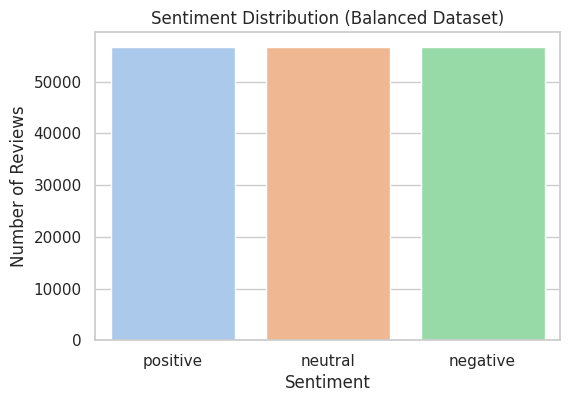

In [81]:
# Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=balanced_data, x='sentiment', order=['positive', 'neutral', 'negative'], palette='pastel')
plt.title("Sentiment Distribution (Balanced Dataset)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

## Rating Distribution (Bar Chart)

This creates a bar chart for the distribution of the ratings (1 to 5 stars). It helps in understanding which ratings are most common among the reviews.



<ipython-input-82-7d4388f54967>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_data, x='rating', palette='muted')


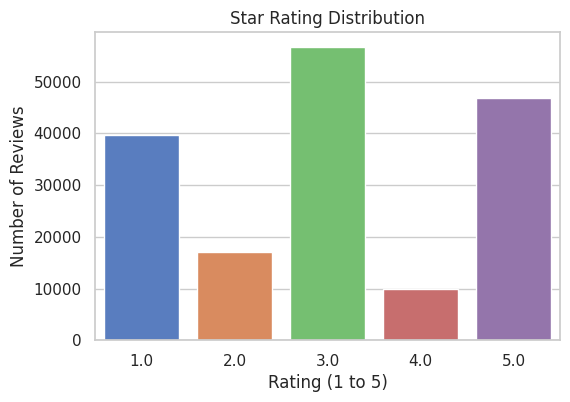

In [82]:
# Rating Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=balanced_data, x='rating', palette='muted')
plt.title("Star Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Number of Reviews")
plt.show()

## Word Cloud of All Reviews

Here, we create a word cloud from the text of all reviews. This gives a visual representation of the most frequently occurring words in the reviews, helping to spot trends or common terms used by customers.

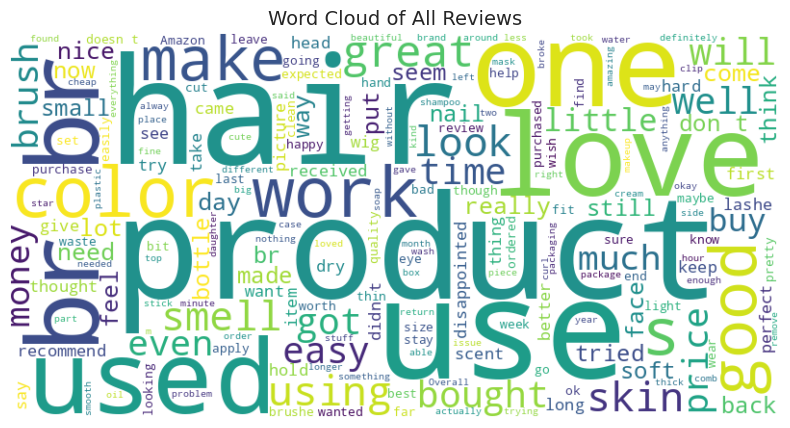

In [83]:
# Word Cloud
all_text = " ".join(balanced_data['review'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of All Reviews", fontsize=14)
plt.show()

## Review Length Distribution

This section calculates the length of each review and then creates a histogram to visualize the distribution of review lengths (i.e., how many reviews are short, medium, or long).



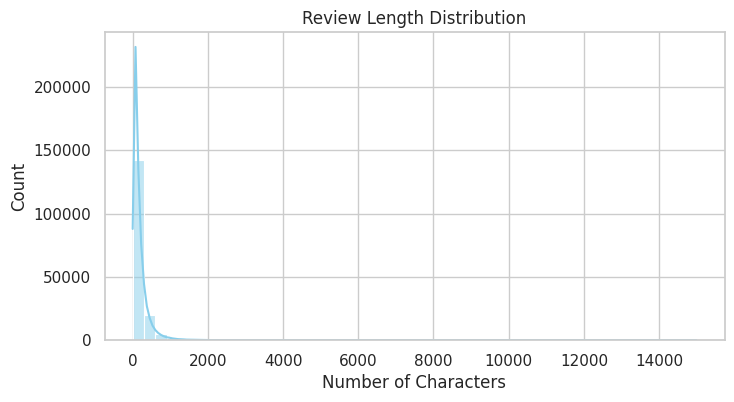

In [84]:
# Review Length Distribution
balanced_data['review_length'] = balanced_data['review'].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(balanced_data['review_length'], bins=50, kde=True, color='skyblue')
plt.title("Review Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

## Average Rating per Review Length Bucket

In this part, the reviews are grouped into length buckets (e.g., 0–100 characters, 100–300 characters, etc.). Then, the average rating for each length bucket is calculated and visualized as a bar chart.



<ipython-input-85-4a0816a328d1>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating = balanced_data.groupby('length_bucket')['rating'].mean()


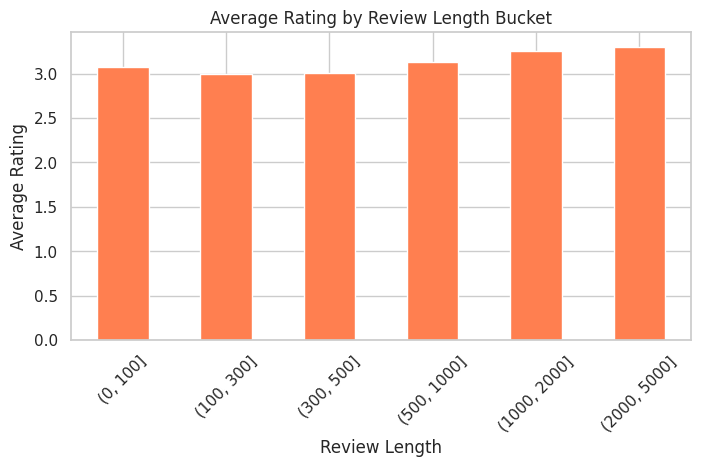

In [85]:
# Average Rating per Review Length Bucket
balanced_data['length_bucket'] = pd.cut(balanced_data['review_length'],
                                      bins=[0, 100, 300, 500, 1000, 2000, 5000])

avg_rating = balanced_data.groupby('length_bucket')['rating'].mean()

avg_rating.plot(kind='bar', color='coral', figsize=(8,4))
plt.title("Average Rating by Review Length Bucket")
plt.xlabel("Review Length")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

# 4: Model (roberta-base)

## (A) Tokenization

In [86]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Convert to lists for tokenizer
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

train_encodings = tokenizer(X_train_list, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test_list, truncation=True, padding=True, max_length=128)

## (B) Encrypted data storage and classifications

In [87]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## (C) Prepare data sets

In [88]:
train_dataset = ReviewDataset(train_encodings, y_train.tolist())
test_dataset = ReviewDataset(test_encodings, y_test.tolist())

## (D) Load RoBERTa model

In [89]:
# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## (E) Metrics function

In [90]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

    return {
        'accuracy': accuracy,
        'precision_negative': precision[0],
        'precision_neutral': precision[1],
        'precision_positive': precision[2],
        'recall_negative': recall[0],
        'recall_neutral': recall[1],
        'recall_positive': recall[2],
        'f1_negative': f1[0],
        'f1_neutral': f1[1],
        'f1_positive': f1[2]
    }

## (F) Training settings

In [91]:
training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),  # Enable only if GPU available
    learning_rate=2e-5
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## (G) Trainer

In [92]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [93]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Negative,Precision Neutral,Precision Positive,Recall Negative,Recall Neutral,Recall Positive,F1 Negative,F1 Neutral,F1 Positive
1,0.523100,0.505975,0.785580,0.754334,0.725643,0.867600,0.825044,0.624548,0.907151,0.788106,0.671311,0.886935
2,0.472400,0.504393,0.792252,0.802608,0.697584,0.875894,0.759788,0.710255,0.906710,0.780612,0.703862,0.891036
3,0.423400,0.499609,0.795191,0.788711,0.701304,0.897445,0.782451,0.711137,0.891985,0.785569,0.706186,0.894707
4,0.365400,0.531592,0.793281,0.775273,0.700893,0.907389,0.800705,0.698792,0.880346,0.787784,0.699841,0.893663


Epoch,Training Loss,Validation Loss,Accuracy,Precision Negative,Precision Neutral,Precision Positive,Recall Negative,Recall Neutral,Recall Positive,F1 Negative,F1 Neutral,F1 Positive
1,0.523100,0.505975,0.785580,0.754334,0.725643,0.867600,0.825044,0.624548,0.907151,0.788106,0.671311,0.886935
2,0.472400,0.504393,0.792252,0.802608,0.697584,0.875894,0.759788,0.710255,0.906710,0.780612,0.703862,0.891036
3,0.423400,0.499609,0.795191,0.788711,0.701304,0.897445,0.782451,0.711137,0.891985,0.785569,0.706186,0.894707
4,0.365400,0.531592,0.793281,0.775273,0.700893,0.907389,0.800705,0.698792,0.880346,0.787784,0.699841,0.893663
5,0.327800,0.567691,0.790959,0.776993,0.700098,0.895230,0.786243,0.693061,0.893572,0.781591,0.696562,0.894400


TrainOutput(global_step=21265, training_loss=0.4381109047967519, metrics={'train_runtime': 2944.84, 'train_samples_per_second': 231.055, 'train_steps_per_second': 7.221, 'total_flos': 4.475690792262144e+16, 'train_loss': 0.4381109047967519, 'epoch': 5.0})

In [104]:
# Evaluate the trained model using the validation set
eval_results = trainer.evaluate()
print("\nEvaluation results:")
print(eval_results)


Evaluation results:
{'eval_loss': 0.4996088147163391, 'eval_accuracy': 0.7951913467756158, 'eval_precision_negative': 0.7887111111111111, 'eval_precision_neutral': 0.701304347826087, 'eval_precision_positive': 0.897444996451384, 'eval_recall_negative': 0.7824514991181658, 'eval_recall_neutral': 0.7111365840754783, 'eval_recall_positive': 0.8919848337889075, 'eval_f1_negative': 0.7855688357680389, 'eval_f1_neutral': 0.7061862440348496, 'eval_f1_positive': 0.8947065847079114, 'eval_runtime': 27.8157, 'eval_samples_per_second': 1223.124, 'eval_steps_per_second': 38.252, 'epoch': 5.0}


## (H) Confusion Matrix

In [95]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

Accuracy: 0.7952

RoBERTa Classification Report:
Negative:
  Precision: 0.7887
  Recall:    0.7825
  F1-score:  0.7856
Neutral:
  Precision: 0.7013
  Recall:    0.7111
  F1-score:  0.7062
Positive:
  Precision: 0.8974
  Recall:    0.8920
  F1-score:  0.8947


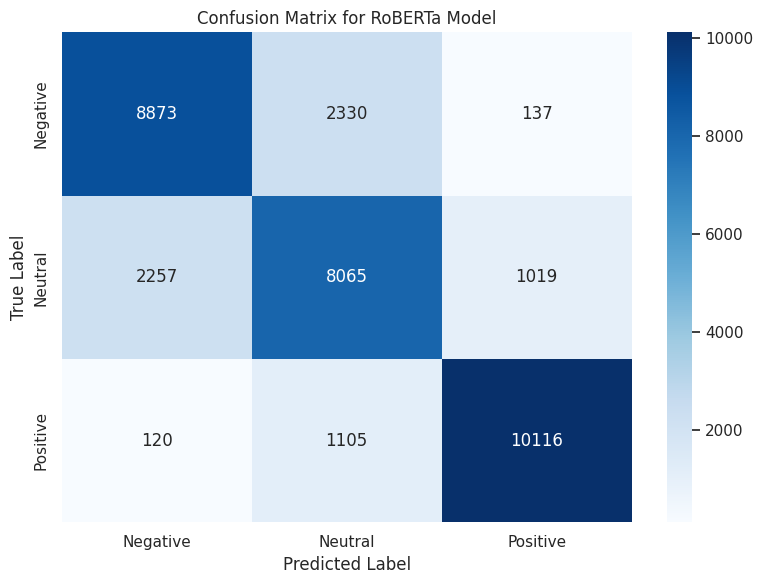

In [98]:
# RoBERTa Model Evaluation Metrics and Confusion Matrix

roberta_accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {roberta_accuracy:.4f}")

roberta_precision, roberta_recall, roberta_f1, _ = precision_recall_fscore_support(
    true_labels, preds, average=None, labels=[0, 1, 2]
)
roberta_classes = ["Negative", "Neutral", "Positive"]

print("\nRoBERTa Classification Report:")
for i, cls in enumerate(roberta_classes):
    print(f"{cls}:")
    print(f"  Precision: {roberta_precision[i]:.4f}")
    print(f"  Recall:    {roberta_recall[i]:.4f}")
    print(f"  F1-score:  {roberta_f1[i]:.4f}")

roberta_cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(roberta_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=roberta_classes, yticklabels=roberta_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RoBERTa Model')
plt.tight_layout()
plt.show()

## (I) Save the best model

In [99]:
# Save the best model locally
model.save_pretrained("./roberta_model")
tokenizer.save_pretrained("./roberta_model")
print("✅ RoBERTa model and tokenizer have been saved locally to ./roberta_model")

✅ RoBERTa model and tokenizer have been saved locally to ./roberta_model


In [103]:
# Save the model and tokenizer to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the save path in Google Drive
save_path = "/content/drive/MyDrive/roberta_model"

# Save the model and tokenizer to Google Drive
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("✅ RoBERTa model and tokenizer have been saved to Google Drive at:", save_path)

Mounted at /content/drive
✅ RoBERTa model and tokenizer have been saved to Google Drive at: /content/drive/MyDrive/roberta_model
